# Advanced Line Finding

# Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from line import Line

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def plot_images(images, cols=5, figsize=(8, 4)):
    n_img = len(images)
    rows = math.ceil(n_img/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    subplots = axes.ravel()

    for n, subplot in enumerate(subplots):
        if (n < n_img):
            image = images[n]
            if len(image.shape) < 3:
                subplots[n].imshow(image, cmap='gray')
            else:
                subplots[n].imshow(image)
            subplots[n].axis('off')
        else:
            subplots[n].axis('off')
    plt.show()

### Load calibration images

In [3]:
calibration_files = glob.glob('camera_cal/calibration*.jpg')
calibration_images = []

In [4]:
for file in calibration_files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    calibration_images.append(img)

### Extract calibration points from chessboard corners

In [5]:
object_points = []
image_points = []
pattern_size = (9, 6)

# object_point.shape => (54, 3)
object_point = np.zeros((6*9, 3), np.float32)

# np.mgrid[0:9, 0:6].T.shape => (6, 9, 2)
# np.mgrid[0:9, 0:6].T.reshape(-1, 2).shape => (54, 2)
object_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for image in calibration_images:
    ret, corners = cv2.findChessboardCorners(image, patternSize=pattern_size)

    if ret is True:
        object_points.append(object_point)
        image_points.append(corners)

        cv2.drawChessboardCorners(image,
                                  patternSize=pattern_size,
                                  corners=corners,
                                  patternWasFound=ret)

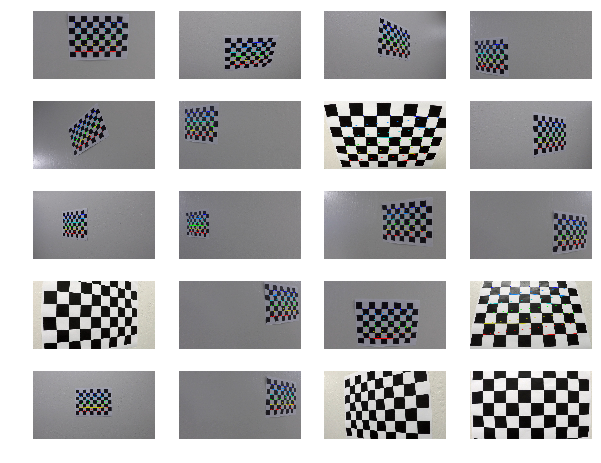

In [6]:
plot_images(calibration_images, cols=4, figsize=(10, 8))

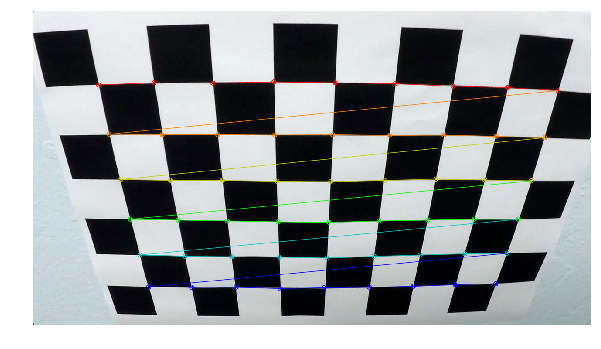

In [7]:
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(calibration_images[6], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Distortion Correction

In [8]:
image_shape = calibration_images[0].shape

In [9]:
w = image_shape[1]
h = image_shape[0]

image_size = (w, h)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=object_points,
                                                   imagePoints=image_points,
                                                   imageSize=image_size,
                                                   cameraMatrix=None,
                                                   distCoeffs=None)

In [10]:
undistorted_images = []

for image in calibration_images:
    dst = cv2.undistort(image, cameraMatrix=mtx, distCoeffs=dist)
    undistorted_images.append(dst)

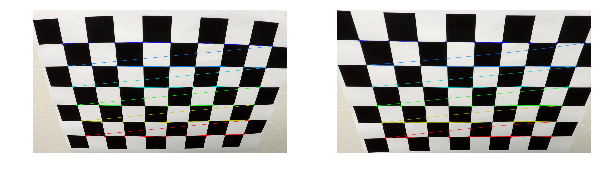

In [11]:
plot_images([calibration_images[6], undistorted_images[6]],
            cols=2, figsize=(10, 6))

### Load sample images

In [12]:
sample_files = glob.glob('test_images/*.jpg')
sample_images = []

for file in sample_files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_images.append(img)

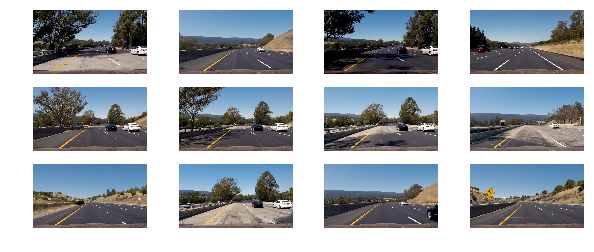

In [13]:
plot_images(sample_images, cols=4, figsize=(10, 4))

### Undistort a sample image

In [14]:
original_img = np.zeros_like(sample_images[8])
np.copyto(dst=original_img, src=sample_images[8])
undistorted_img = cv2.undistort(original_img,
                                cameraMatrix=mtx, distCoeffs=dist)

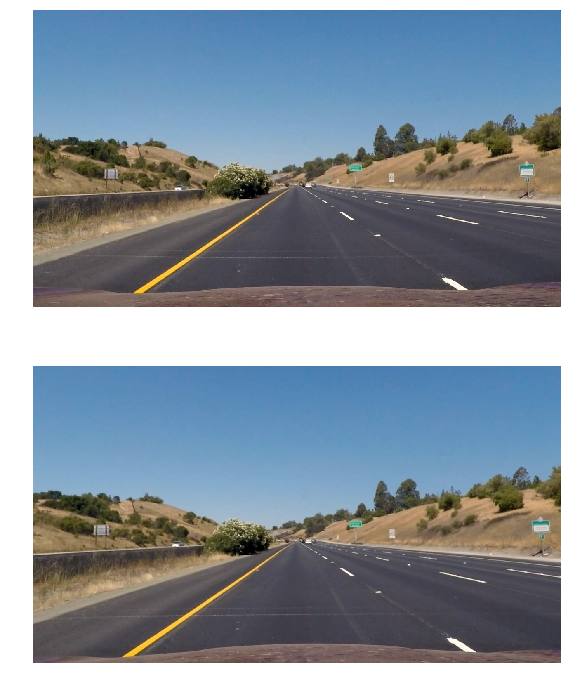

In [15]:
plot_images([original_img, undistorted_img], cols=1, figsize=(10, 12))

# Threshold Binary Image

In [16]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [17]:
def region_of_interest(image, vertices):

    mask = np.zeros_like(image)
    channel_count = image.shape[2] if len(image.shape) > 2 else 1 
    ignore_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, pts=vertices, color=ignore_mask_color)
    roi = cv2.bitwise_and(image, mask)

    return roi

In [18]:
def mask(image):

    h = image.shape[0]
    w = image.shape[1]
    vertices = np.array([[
        (0, h),
        (w/2 - 40, h/2 + 50),
        (w/2 + 40, h/2 + 50),
        (w, h),
    ]], dtype=np.int32)
    roi = region_of_interest(image, vertices)

    return roi

In [19]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))

    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) &
                  (scaled_sobel <= thresh_max)] = 1

    return binary_output

In [20]:
def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Gradient magnitude
    grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

    # 8-bit rescale
    scale = np.max(grad_mag)/255
    mag = (grad_mag/scale).astype(np.uint8)

    # Binary thresholding
    binary_output = np.zeros_like(mag)
    selected = (mag >= thresh[0]) & (mag <= thresh[1])
    binary_output[selected] = 1

    return binary_output

In [21]:
def dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Sobel gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Gradient direction
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output = np.zeros_like(abs_grad_dir)
    selected = (abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])
    binary_output[selected] = 1

    return binary_output

In [22]:
def hls_select(image, thresh=(0, 255)):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    selected = (s_channel > thresh[0]) & (s_channel <= thresh[1])
    binary_output[selected] = 1

    return binary_output

In [23]:
def hsv_white(image):
    white = cv2.inRange(cv2.cvtColor(image, cv2.COLOR_RGB2HSV),
                        lowerb=(0, 0, 220),     # lowerb=(0, 0, 250)
                        upperb=(180, 255, 255))
    return white

In [24]:
def hsv_yellow(image):
    yellow = cv2.inRange(cv2.cvtColor(image, cv2.COLOR_RGB2HSV),
                         lowerb=(20, 100, 100),
                         upperb=(30, 255, 255))
    return yellow

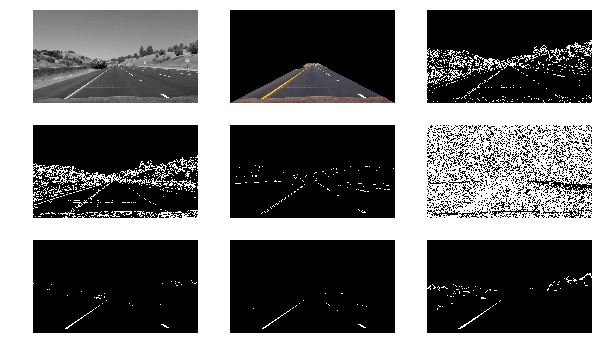

In [25]:
original_gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

plot_images([grayscale(original_img),
             mask(original_img),
             abs_sobel_thresh(original_gray_img, orient='x', thresh_min=10, thresh_max=80),
             abs_sobel_thresh(original_gray_img, orient='y', thresh_min=10, thresh_max=80),
             mag_thresh(original_gray_img, sobel_kernel=9, thresh=(100, 255)),
             dir_thresh(original_gray_img, sobel_kernel=15, thresh=(0.19, 1.37)),
             hls_select(original_img, thresh=(180, 255)),
             hsv_white(original_img),
             hsv_yellow(original_img)], cols=3, figsize=(10, 6))

# Calculate Mapping Points

In [26]:
# plt.imshow(undistorted_parallel_img)
# plt.show()

src = np.float32(
    [[748, 490],
     [1073, 700],
     [235, 700],
     [540, 494]])

dst = np.float32(
    [[1080, 490],
     [1073, 700],
     [235, 700],
     [270, 490]])

In [27]:
def warper(img, src, dst):
    size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M=M, dsize=size, flags=cv2.INTER_NEAREST)

    return warped

In [28]:
curve_img = np.zeros_like(sample_images[11])
np.copyto(dst=curve_img, src=sample_images[11])
undistorted_curve_img = cv2.undistort(curve_img,
                                      cameraMatrix=mtx, distCoeffs=dist)

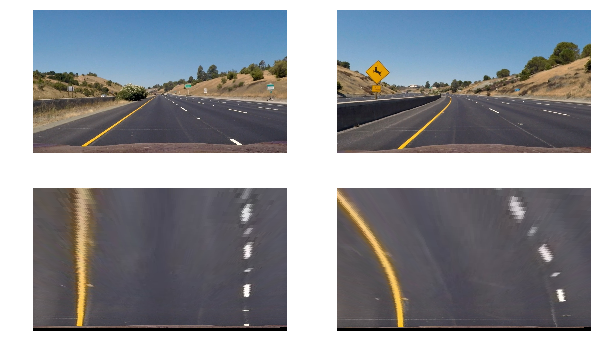

In [29]:
plot_images([original_img,
             undistorted_curve_img,
             warper(original_img, src, dst),
             warper(undistorted_curve_img, src, dst)],
            cols=2, figsize=(10, 6))

# Pipeline

In [30]:
def pipeline(image):
    gray = grayscale(image)
    masked = mask(gray)
    magnitude = mag_thresh(gray, sobel_kernel=9, thresh=(100, 255))
    direction = dir_thresh(gray, sobel_kernel=15, thresh=(0.19, 1.37))
    
    # HLS channel
    # s_channel = hls_select(image, thresh=(160, 255))

    # HSV channel
    yellow = hsv_yellow(image)
    white = hsv_white(image)

    binary_output = ((masked > 0) &
                     (((magnitude == 1) & (direction == 1)) | (yellow | white)))

    return binary_output

In [31]:
def binary_warper(image, src, dst):
    return warper(pipeline(image).astype(np.uint8), src, dst)

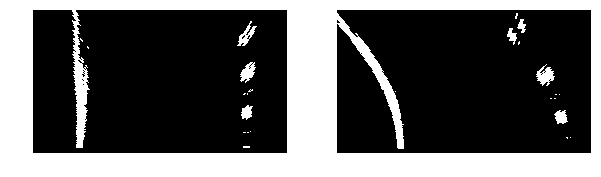

In [32]:
plot_images([binary_warper(original_img, src, dst), binary_warper(undistorted_curve_img, src, dst)], 
            cols=2, figsize=(10, 4))

# Detect Lane Lines

In [33]:
def fit_lane_lines(binary_warped):

    mid_height = np.int(binary_warped.shape[0]/2)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[mid_height:, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    n_windows = 5

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 200

    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Create empty lists to receive left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      pt1=(win_xleft_low, win_y_low),
                      pt2=(win_xleft_high, win_y_high),
                      color=(0, 255, 0), thickness=8)

        cv2.rectangle(out_img,
                      pt1=(win_xright_low, win_y_low),
                      pt2=(win_xright_high, win_y_high),
                      color=(0, 255, 0), thickness=8)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) &
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_indices.append(good_left_inds)
        right_lane_indices.append(good_right_inds)

        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return (left_fit, right_fit)

In [34]:
def generate_lane_lines(binary_warped, left_fit, right_fit):
    h = binary_warped.shape[0]
    w = binary_warped.shape[1]
    fit_y = np.linspace(0, h-1, h)
    fit_leftx = left_fit[0] * fit_y**2 + left_fit[1] * fit_y + left_fit[2]
    fit_rightx = right_fit[0] * fit_y**2 + right_fit[1] * fit_y + right_fit[2]

    lidx = np.logical_and(fit_leftx >= 0, fit_leftx < w)
    left_poly = np.transpose(np.vstack([fit_leftx[lidx],
                                        fit_y[lidx]]))

    ridx = np.logical_and(fit_rightx >= 0, fit_rightx < w)
    right_poly = np.transpose(np.vstack([fit_rightx[ridx],
                                         fit_y[ridx]]))

    return (np.int_(left_poly), np.int_(right_poly))

In [35]:
def generate_center_line(image):
    h = image.shape[0]
    w = image.shape[1]
    y = np.int_(np.linspace(h-h/8, h-1, h))
    x = np.int_(np.ones_like(y) * w/2)

    return np.array([np.transpose(np.vstack([x, y]))])

### Complete example

(655, 719)


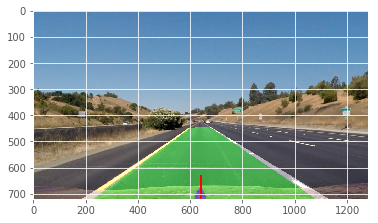

In [36]:
binary_warped = binary_warper(original_img, src, dst)

left_fit, right_fit = fit_lane_lines(binary_warped)
left_poly, right_poly = generate_lane_lines(binary_warped, left_fit, right_fit)

overlay = np.zeros_like(original_img)

poly = np.hstack((np.array([np.flipud(left_poly)]),
                  np.array([right_poly])))


cv2.fillPoly(overlay,
             pts=poly,
             color=[0, 255, 0])

cv2.polylines(overlay,
              pts=np.array([left_poly]),
              isClosed=False,
              color=[255, 255, 255], thickness=40, lineType=cv2.LINE_AA)

cv2.polylines(overlay,
              pts=np.array([right_poly]),
              isClosed=False,
              color=[255, 255, 255], thickness=40, lineType=cv2.LINE_AA)


lane_center = (np.int_((right_poly[-1][0] + left_poly[-1][0])/2),
               overlay.shape[0] - 1)


cv2.circle(overlay,
           center=lane_center,
           radius=25,
           color=[0, 0, 255], thickness=-1, lineType=cv2.LINE_AA)

final_img = cv2.addWeighted(src1=original_img,
                            alpha=1.0,
                            src2=warper(overlay, src=dst, dst=src),
                            beta=0.4,
                            gamma=1)

cv2.polylines(final_img,
              pts=generate_center_line(final_img),
              isClosed=False,
              color=[255, 0, 0], thickness=4, lineType=cv2.LINE_AA)

print(lane_center)

plt.imshow(final_img)
plt.show()

# Measuring Curvature

In [37]:
def measure_curvature(left_poly, right_poly):
    left_y = left_poly[:, 1]
    left_x = left_poly[:, 0]

    right_y = right_poly[:, 1]
    right_x = right_poly[:, 0]

    y_max = np.max(left_y)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_radius = ((1 + (2*left_fit[0]*y_max*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_max*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return (left_radius, right_radius)

In [38]:
left_curve, right_curve = measure_curvature(left_poly, right_poly)
print(left_curve, 'm', right_curve, 'm')

1050.32176736 m 28284.0496971 m


In [39]:
def measure_vehicle_position(image, left_poly, right_poly):
    # meters from center
    xm_per_pix = 3.7/700  # meteres per pixel in x dimension

    middle_pix = image.shape[1]/2

    left_lane_pixel = left_poly[-1][0]
    # x position for left lane
    right_lane_pixel = right_poly[-1][0]
    # x position for right lane

    car_pix = int((right_lane_pixel + left_lane_pixel)/2)
    off_center = middle_pix - car_pix
    vehicle_pos = xm_per_pix * off_center

    return vehicle_pos

In [40]:
vehicle_pos = measure_vehicle_position(original_img, left_poly, right_poly)
print(vehicle_pos)

-0.07928571428571429


# Video Processing

In [41]:
def process_frame(image):
    # global i
    try:
        frame = process_image(image)
    except Exception as e:
        frame = image
        print(e)
    finally:
        # cv2.imwrite('frames/{}-picture-frame.jpg'.format(i), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        # i += 1
        return frame

In [42]:
left_line = Line('left')
right_line = Line('right')

In [43]:
def process_image(image):
    # global n_frame

    binary_warped = binary_warper(image, src, dst)

    left_fit, right_fit = fit_lane_lines(binary_warped)

    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)

    # Average the last 12 frames
    avg_left_fit = left_line.average_fit()
    avg_right_fit = right_line.average_fit()

    left_poly, right_poly = generate_lane_lines(binary_warped,
                                                avg_left_fit,
                                                avg_right_fit)

    # TODO
    left_curve, right_curve = measure_curvature(left_poly, right_poly)

    # TODO
    vehicle_pos = measure_vehicle_position(image, left_poly, right_poly)

    overlay = np.zeros_like(image)

    poly = np.hstack((np.array([np.flipud(left_poly)]),
                      np.array([right_poly])))

    cv2.fillPoly(overlay,
                 pts=poly,
                 color=[0, 255, 0])

    cv2.polylines(overlay,
                  pts=np.array([left_poly]),
                  isClosed=False,
                  color=[255, 255, 255], thickness=40, lineType=cv2.LINE_AA)

    cv2.polylines(overlay,
                  pts=np.array([right_poly]),
                  isClosed=False,
                  color=[255, 255, 255], thickness=40, lineType=cv2.LINE_AA)

    lane_center = (np.int_((right_poly[-1][0] + left_poly[-1][0])/2),
                   overlay.shape[0] - 1)

    cv2.circle(overlay,
               center=lane_center,
               radius=25,
               color=[0, 0, 255], thickness=-1, lineType=cv2.LINE_AA)

    final_img = cv2.addWeighted(src1=image, alpha=1.0,
                                src2=warper(overlay, src=dst, dst=src),
                                beta=0.4, gamma=1)

    cv2.polylines(final_img,
                  pts=generate_center_line(final_img),
                  isClosed=False,
                  color=[255, 0, 0], thickness=2, lineType=cv2.LINE_AA)

    # Annotations
    # left_curve, right_curve = measure_curvature(left_poly, right_poly)
    # vehicle_pos = measure_vehicle_position(image, left_poly, right_poly)
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(final_img,
                'radius of curvature: {:>8.2f}m'.format(left_curve),
                (20, 60), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.putText(final_img,
                '    vehicle position: {:>8.2f}m'.format(vehicle_pos),
                (20, 100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    side = 'left' if (vehicle_pos < 0) else 'right'
    cv2.putText(final_img,
                '(to the {} of the lane center)'.format(side),
                (20, 140), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Picture in Picture
    pipe = np.zeros_like(image)
    pipe[:, :, 0] = binary_warped * 255
    picture = cv2.addWeighted(src1=pipe, alpha=1.0,
                              src2=overlay,
                              beta=0.2, gamma=1)
    final_img[10:(180+10), (w-10)-320:(w-10)] = cv2.resize(picture,
                                                           dsize=(320, 180))

    return final_img

In [44]:
%%time

video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
# video_output = 'harder_challenge_video_output.mp4'
# clip = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip.fl_image(process_frame)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:30<00:00,  7.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 10s, sys: 4.38 s, total: 3min 14s
Wall time: 2min 31s


In [45]:
left_line = Line('left')
right_line = Line('right')
processed_img = process_image(undistorted_img)

In [46]:
left_line = Line('left')
right_line = Line('right')
processed_curve_img = process_image(undistorted_curve_img)

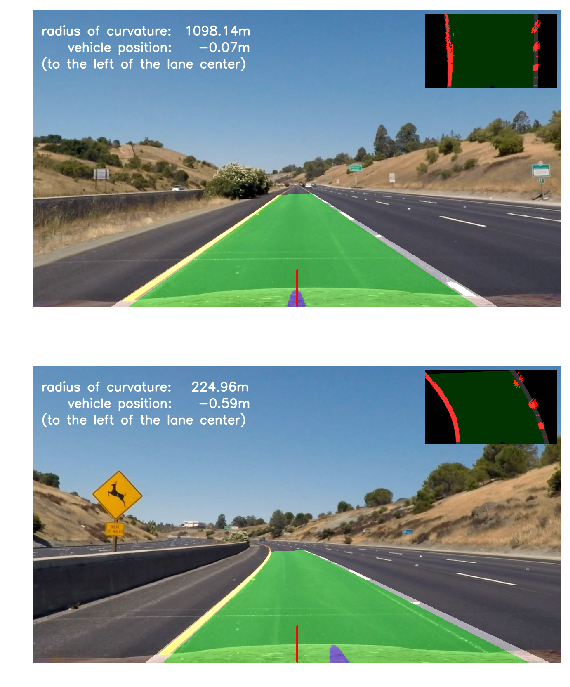

In [47]:
plot_images([processed_img, processed_curve_img], cols=1, figsize=(10, 12))

In [48]:
fail_img = np.zeros_like(sample_images[5])
np.copyto(dst=fail_img, src=sample_images[5])
undistorted_fail_img = cv2.undistort(fail_img,
                                cameraMatrix=mtx, distCoeffs=dist)

In [49]:
left_line = Line('left')
right_line = Line('right')
processed_fail_img = process_image(undistorted_fail_img)

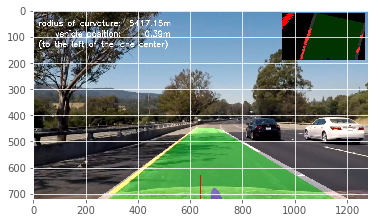

In [50]:
plt.imshow(processed_fail_img)

In [51]:
# # middle panel text example
# # using cv2 for drawing text in diagnostic pipeline.
# font = cv2.FONT_HERSHEY_COMPLEX
# middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
# cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
# cv2.putText(middlepanel, 'Estimated Meters right of center: ERROR!', (30, 90), font, 1, (255,0,0), 2)


# # assemble the screen example
# diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
# diagScreen[0:720, 0:1280] = mainDiagScreen
# diagScreen[0:240, 1280:1600] = cv2.resize(diag1, (320,240), interpolation=cv2.INTER_AREA) 
# diagScreen[0:240, 1600:1920] = cv2.resize(diag2, (320,240), interpolation=cv2.INTER_AREA)
# diagScreen[240:480, 1280:1600] = cv2.resize(diag3, (320,240), interpolation=cv2.INTER_AREA)
# diagScreen[240:480, 1600:1920] = cv2.resize(diag4, (320,240), interpolation=cv2.INTER_AREA)*4
# diagScreen[600:1080, 1280:1920] = cv2.resize(diag7, (640,480), interpolation=cv2.INTER_AREA)*4
# diagScreen[720:840, 0:1280] = middlepanel
# diagScreen[840:1080, 0:320] = cv2.resize(diag5, (320,240), interpolation=cv2.INTER_AREA)
# diagScreen[840:1080, 320:640] = cv2.resize(diag6, (320,240), interpolation=cv2.INTER_AREA)
# diagScreen[840:1080, 640:960] = cv2.resize(diag9, (320,240), interpolation=cv2.INTER_AREA)
# diagScreen[840:1080, 960:1280] = cv2.resize(diag8, (320,240), interpolation=cv2.INTER_AREA)

